# Refund Analysis - Ecom Project - using Time series, Neural Network and Gradient Boosting classifier


## Data



Columns: id,	day,	currency,	type,	item_value,	tax_rate,	shipping_cost,	total_payment,	customer

Customer is a dictionary with the following columns:
Cust id, address



## Requirements




1. For each order, the total_payment represents the sum of item_value plus shipping_cost plus tax. The tax is a percentage applied to both item_value and shipping_cost. When an order is refunded, the shipping_cost is 0 because shipping is paid for by the user. When refunding, the tax on the item_value is also refunded. Compute the total value (in GBP) of the tax element due to the government for all orders and refunds submitted in GBP currency.


2. Compute the repeat rate (the percent of the customers who ordered more than once).

3. Compute the total value (in USD) of all item_value of orders, regardless of which currency the order was submitted in, assuming the item_value was converted from the order currency into USD at the time the order was received. Assume day 0 is January 1st, 2019. Do not include refunds in this analysis.

4.  The available data  contains information up to day 899. Forecast the number of refunds for the next 3 periods of 30 days.
This question requires three numerical answers: number of refunds in days 900-929; number of refunds in days 930-959; number of refunds in days 960-989

5. Estimate the refund probability:

    a. Order sent from FR, in currency GBP, with item_value=351, tax_rate=0.2, shipping_cost=30.

    b. Order sent from US, in currency USD, with item_value=45, tax_rate=0.1, shipping_cost=0.

    c. Order sent from US, in currency CHF, with item_value=200, tax_rate=0.15, shipping_cost=0

    d. Order sent from FR, in currency EUR, with item_value=1500, tax_rate=0.2, shipping_cost=0.

    e. Order sent from AU, in currency EUR, with item_value=750, tax_rate=0.15, shipping_cost=0.

    f. Order sent from DE, in currency EUR, with item_value=800, tax_rate=0.1, shipping_cost=20.

    g. Order sent from US, in currency CHF, with item_value=2500, tax_rate=0.35, shipping_cost=20.

    

## Script

##### Preprocessing

In [4]:
#Import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime,timedelta
from forex_python.converter import CurrencyRates
from statsmodels.tsa.seasonal import seasonal_decompose

In [7]:
#Load input file to a dataset

#Mount GDrive
from google.colab import drive
drive.mount('/content/gdrive')

#Set input data file path
path = "/content/gdrive/My Drive/Colab Notebooks/Ecom - Refund analysis/"


ds = pd.read_json(path+"data.json")

Mounted at /content/gdrive


In [8]:
ds.columns

Index(['id', 'day', 'currency', 'type', 'item_value', 'tax_rate',
       'shipping_cost', 'total_payment', 'customer'],
      dtype='object')

In [ ]:
ds.head(2)

,id,day,currency,type,item_value,tax_rate,shipping_cost,total_payment,customer
0,1a8dda94-a6f2-4b14-a2d4-0fba2dda9974,0,EUR,ORDER,5300.0,0.19,0,6307.0,"{'id': '5a2eadc5-2e11-4b33-b7ea-9c804b013f68',..."
1,ffafaf5d-8c5d-409c-aa84-af5ef8ee203c,0,GBP,ORDER,3130.0,0.10,0,3443.0,"{'id': '2eddfaad-046e-49a6-bda8-f6358024feab',..."


In [ ]:
print(ds['currency'].unique())

['EUR' 'GBP' 'CAD' 'BTC' 'USD' 'ETH' 'CHF']


#### **1. For each order, the total_payment represents the sum of item_value plus shipping_cost plus tax. The tax is a percentage applied to both item_value and shipping_cost. When an order is refunded, the shipping_cost is 0 because shipping is paid for by the user. When refunding, the tax on the item_value is also refunded. Compute the total value (in GBP) of the tax element due to the government for all orders and refunds submitted in GBP currency.**





Steps:
1. Load json to pandas dataset
2. Filter 'GBP' currency records to a new dataset
3. Add a new tax value column 'tax_value' = ('item_value' * 'tax_rate') + ('shipping_cost' * 'tax_rate') 
4. Make 'tax_value' negative for REFUND records by multiplying with -1
dsgbp["tax_value"] = np.where(dsgbp['type'] == "REFUND",dsgbp["tax_value"] *-1, dsgbp["tax_value"]  )

5. Sum up the 'tax_value' column for tax due
Note: 'GBP' records doesn't have 'REFUND' types. So we may skip step 4!



In [ ]:
#Filter GBP currency
dsgbp = ds[ds["currency"] == "GBP"]

In [ ]:
dsgbp.shape

(1048, 9)

In [ ]:
#calculate tax value. add a new col

dsgbp["tax_value"] = (dsgbp["item_value"]*dsgbp['tax_rate']) + (dsgbp["shipping_cost"]*dsgbp['tax_rate'])

In [ ]:
#make refund tx negative
dsgbp["tax_value"] = np.where(dsgbp['type'] == "REFUND",dsgbp["tax_value"] *-1, dsgbp["tax_value"]  )


In [ ]:
tax_due = dsgbp['tax_value'].sum()
tax_due

739431.3500000001


Result : 739431.3500000001


#### **2.** **Compute the repeat rate (the percent of the customers who ordered more than once).**



Steps:
1. With the original dataset, insert a new column 'customerid'
2. Extract values to this new column from 'customer' dictionary
3. Calculate count of customers who ordered more than once
4. Calculate totla number of unique customers
5. Repeat rate = Number of repeat purchase customers/total number of customers


In [ ]:
#number of repeat purchase customers
ds1=ds.copy()
ds1.insert(1,'customerid','')
#create custid column
for i in range(len(ds1)):
    ds1['customerid'][i] =ds['customer'][i]['id']
    
dsr = ds1.groupby('customerid').size()
repeatsize = dsr[dsr>1].count()


In [ ]:
totcust = ds1['customerid'].unique().shape

In [ ]:
totcust

(4521,)

In [ ]:
repeatsize

1646

In [ ]:
rrate = repeatsize/totcust

In [ ]:
rrate


array([0.36407874])

Repeat rate = 0.36407874 or 36.41%

#### **3. Compute the total value (in USD) of all item_value of orders, regardless of which currency the order was submitted in, assuming the item_value was converted from the order currency into USD at the time the order was received. Assume day 0 is January 1st, 2019. Do not include refunds in this analysis.**




Note: 'ETH' currency rate against USD is not exposed by any free API. So skipped 'ETH' records. The above answer is summed up for all currencies except 'ETH'. 

External API used:
 'https://api.apilayer.com/fixer/timeseries?base={0}&start_date={1}&end_date={2}&symbols={3}'

Steps:
1. Exclude 'Refund' records
2. Above timeseries API is used with base='USD', symbols = 'EUR,GBP,CAD,CHF,BTC,ETH',
start_date="2019-01-01" and  end_date = "2021-06-18" to get rates
3. Currency Conversion Rates are extracted from the API response using json and dataframe
4. Conversion Rate is multiplied with item_value to get USD value
5. The USD values are summed up to get the result


In [ ]:
#Remove 'Refund' records/
ds1=ds[ds['type'] == 'ORDER']
ds1.reset_index(inplace=True,drop=True)
ds1.insert(0,'usdrate',ds1['item_value'])
ds1.insert(0,'rate',1.0)


In [ ]:

#import libraries to handle request to api
import requests
import json

# base currency or reference currency
base='USD'

# required currency for plot
symbols = 'EUR,GBP,CAD,CHF,BTC,ETH'

#Get response in batch of three since only api returns a years response at a time

start_date="2019-01-01"
end_date = "2020-01-01"
url = 'https://api.apilayer.com/fixer/timeseries?base={0}&start_date={1}&end_date={2}&symbols={3}'.format(base,start_date,end_date,symbols)
payload = {}
headers= {
  "apikey": "vMGHPcDgzaJYRUwuUlO8lRyLKmShq9hc"
}
response1 = requests.request("GET", url, headers=headers, data = payload)
data1 = response1.json()['rates']


start_date="2020-01-02"
end_date = "2021-01-01"
url = 'https://api.apilayer.com/fixer/timeseries?base={0}&start_date={1}&end_date={2}&symbols={3}'.format(base,start_date,end_date,symbols)
payload = {}
headers= {
  "apikey": "vMGHPcDgzaJYRUwuUlO8lRyLKmShq9hc"
}
response2 = requests.request("GET", url, headers=headers, data = payload)
# retrive response in json format
data2 = response2.json()['rates']

start_date="2021-01-02"
end_date = "2021-06-19"
url = 'https://api.apilayer.com/fixer/timeseries?base={0}&start_date={1}&end_date={2}&symbols={3}'.format(base,start_date,end_date,symbols)
payload = {}
headers= {
  "apikey": "vMGHPcDgzaJYRUwuUlO8lRyLKmShq9hc"
}
response3 = requests.request("GET", url, headers=headers, data = payload)
# retrive response in json format
data3 = response3.json()['rates']

datanew = {}
for d in (data1, data2, data3): datanew.update(d)



In [ ]:
from pandas import json_normalize 
dfnew = json_normalize(datanew)

In [ ]:
dfnew1 = dfnew.copy()
for col in dfnew.columns:
    dfnew1[col] = 1/dfnew1[col] 

In [ ]:
dfnew1

,2019-01-01.EUR,2019-01-01.GBP,2019-01-01.CAD,2019-01-01.CHF,2019-01-01.BTC,2019-01-02.EUR,2019-01-02.GBP,2019-01-02.CAD,2019-01-02.CHF,2019-01-02.BTC,...,2021-06-18.EUR,2021-06-18.GBP,2021-06-18.CAD,2021-06-18.CHF,2021-06-18.BTC,2021-06-19.EUR,2021-06-19.GBP,2021-06-19.CAD,2021-06-19.CHF,2021-06-19.BTC
0,1.146125,1.275348,0.733872,1.018123,3846.153846,1.131753,1.252039,0.733533,1.011276,3921.568627,...,1.186349,1.381151,0.80204,1.083365,35766.360257,1.186435,1.381151,0.80204,1.083365,35593.523246


In [ ]:
ds2=ds1.copy()
ds1 = ds1[ds1['currency'] !='ETH']
ds1.reset_index(inplace=True,drop=True)
ds1.shape

(5652, 11)

In [ ]:
dtzero = '2019-01-01'
dtzero=datetime.strptime(dtzero, '%Y-%m-%d')
#dt = pd.to_datetime(dt, format='%Y-%m-%d')

for i in range(len(ds1)):
    if ds1['currency'][i] != 'USD':
        dt =  dtzero+timedelta(days = int(ds1['day'][i]) )
        dt = datetime.strftime(dt, '%Y-%m-%d')
        col = dt + '.' + str(ds1['currency'][i])
        rate = dfnew1[col]
        #rate = (dnew[ds1['day'][i] == dnew['day'] & ds1['currency'][i]==  dnew['currency']]).rate
        ds1['usdrate'][i] = rate * ds1['item_value'][i]
        ds1['rate'][i]=rate

In [ ]:
ds1['usdrate'].sum()

28582197.514796976

Result : 28582197.51 USD + ETH values


In [ ]:
import warnings                   # To ignore the warnings
warnings.filterwarnings("ignore")

#### **4. The data provided contains information up to day 899. Forecast the number of refunds for the next 3 periods of 30 days**.





This requirement was addressed using ARIMA Timeseries model 
1. A timeseries of 30 periods and corresponding refund counts for the existing 900 days was arrived.
2. ETS Decomposition of 'Refund' records shows high 'Trend' and minimal 'Seasonality'. The trend increases steadily with slight fluctuation over the periods. 
3. Parameter Analysis for the ARIMA model was carried out using 'auto-arima' function
3. SARIMAX function from statsmodel is used to fit the model and the final predictions are arrived


In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
#Filter refund data
dfrf =ds[ds['type'] == 'REFUND']
dfrf.shape
dfrf.insert(0,'period','')
dfrf.reset_index(inplace=True,drop=True)

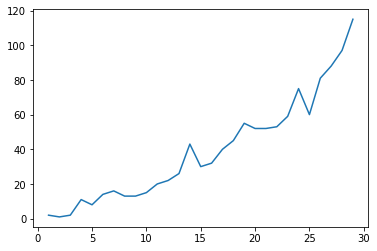

In [ ]:
#Divide the data into periods of 30 days
bins=range(0,901,30)
for i in range(len(bins)):
    for j in range(len(dfrf)):
        
        if  (dfrf['day'][j] >= bins[i]) and (dfrf['day'][j] < bins[i+1]):
            dfrf['period'][j] = i
            
ts = dfrf.groupby(['period']).size()
dfts=pd.DataFrame(ts)
plt.plot(dfts)
plt.show()

##### ARIMA model


###### ETS Decomposition of the Dataset:



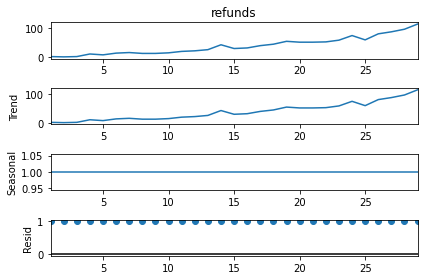

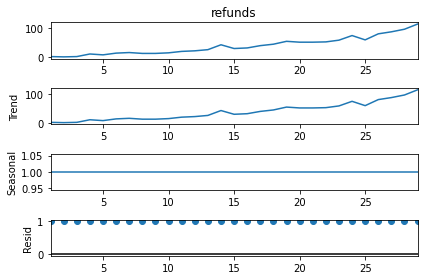

In [ ]:
result = seasonal_decompose(df1['refunds'],  model ='multiplicative',period = 1)
result.plot()

In [ ]:
!pip install pmdarima
from pmdarima import auto_arima


###### Parameter Analysis for the ARIMA model



In [ ]:
train = dfts.iloc[:len(dfts)-3]
test = dfts.iloc[len(dfts)-3:]


In [ ]:
stepwise_fit = auto_arima(df1, start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise
  
# To print the summary
stepwise_fit.summary()


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=128.758, Time=0.08 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=123.661, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=126.978, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=126.792, Time=0.05 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=125.420, Time=0.05 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=125.420, Time=0.04 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=127.420, Time=0.05 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=125.201, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=124.989, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=126.928, Time=0.03 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=124.213, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 0.430 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   29
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 -60.830
Date:                            Wed, 15 Mar 2023   AIC                            123.661
Time:                                    17:27:55   BIC                            124.433
Sample:                                         0   HQIC                           123.700
                                             - 29                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       117.4362     51.643      2.274      0.023      16.218     218.655
===================================================================================
Ljung-Box (L1) (Q):                   0.90   Jarque-Bera (JB):                 0.50
Prob(Q):                              0.34   Prob(JB):                         0.78
Heteroskedasticity (H):               1.34   Skew:                            -0.40
Prob(H) (two-sided):                  0.76   Kurtosis:                         2.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

###### Fit ARIMA Model to the dataset



In [ ]:
#order and seasonal order are adjusted to get best fit

from statsmodels.tsa.statespace.sarimax import SARIMAX
  
#sarimodel = SARIMAX(dfts, 
 #               order = (0, 1, 1), 
  #              seasonal_order =(0, 1, 0, 12))

sarimodel = SARIMAX(dfts, 
                order = (0, 1, 0), 
                seasonal_order =(0, 1, 1, 11))
  
result = sarimodel.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    0   No. Observations:                   29
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 11)   Log Likelihood                 -67.595
Date:                              Thu, 16 Mar 2023   AIC                            139.189
Time:                                      12:18:49   BIC                            140.856
Sample:                                           0   HQIC                           139.355
                                               - 29                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L11      -0.9961    250.778     -0.004      0.997    -492.512     490.519
sigma2        92.4528   2.32e+04      0.004      0.997   -4.54e+04    4.56e+04
===================================================================================
Ljung-Box (L1) (Q):                   4.40   Jarque-Bera (JB):                 1.75
Prob(Q):                              0.04   Prob(JB):                         0.42
Heteroskedasticity (H):               2.63   Skew:                            -0.74
Prob(H) (two-sided):                  0.26   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='period'>

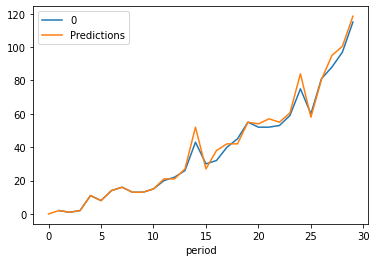

In [ ]:
start = 0
end = len(dfts)
  
# Predictions 
predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")
  
# plot predictions and actual values
dfts.plot(legend = True)
predictions.plot(legend = True)
#test[0].plot(legend = True)


###### Forecasting using the Model :



<AxesSubplot:xlabel='period'>

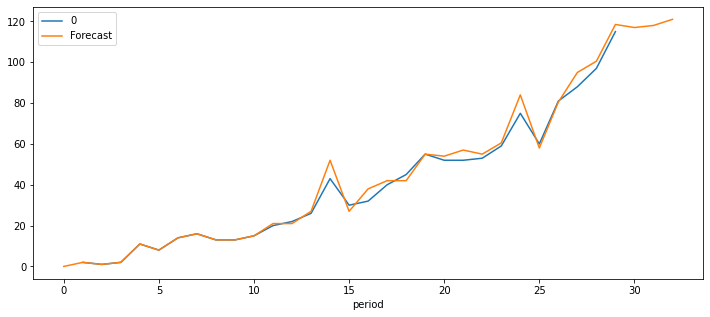

In [ ]:
# Forecast for the next 3 periods
forecast = result.predict(start = 0, 
                          end = len(dfts)+3, 
                          typ = 'levels').rename('Forecast')
  
# Plot the forecast values
dfts.plot(figsize = (12, 5), legend = True)
forecast.plot(legend = True)

In [ ]:
forecast

0       0.000000
1       2.000000
2       1.000000
3       2.000000
4      11.000000
5       8.000000
6      14.000000
7      16.000000
8      13.000000
9      13.000000
10     15.000000
11     21.000000
12     21.000092
13     26.999908
14     51.999171
15     27.000276
16     37.999448
17     41.999816
18     42.000276
19     55.000000
20     53.999816
21     56.999540
22     54.999816
23     60.499950
24     83.999647
25     58.000008
26     80.500042
27     94.999685
28    100.499850
29    118.499889
30    116.999946
31    117.999893
32    120.999739
Name: Forecast, dtype: float64

In [ ]:
predictions = forecast[:-4]

######  Evaluate the model using MSE and RMSE


In [ ]:
# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
  
# Calculate root mean squared error
print(rmse(dfts, predictions))
  
# Calculate mean squared error
print(mean_squared_error(dfts, predictions))

[49.49886798 47.92594863 48.7084925  47.92594863 41.30750955 43.41857222
 39.31218991 38.05531364 39.96334527 39.96334527 38.67593032 35.21510256
 35.21505468 32.5020242  32.64722099 32.50188471 30.10902144 30.20046316
 30.20050416 33.92639091 33.4755923  34.89616502 33.92630575 36.79448454
 53.86992154 35.41381398 51.00417521 63.2940548  68.18350466]
95.78258966205406


<AxesSubplot:xlabel='period'>

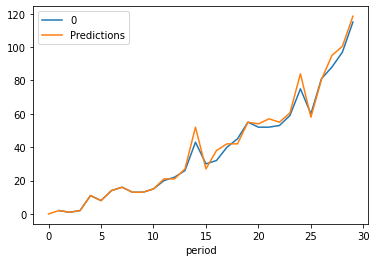

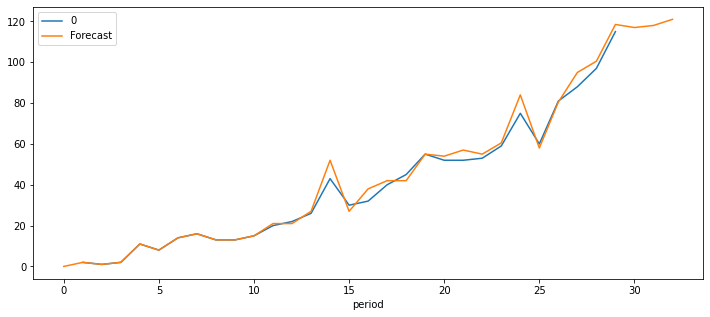

In [ ]:
#order and seasonal order are adjusted to get best fit

from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimodel = SARIMAX(dfts, 
                order = (0, 1, 0), 
                seasonal_order =(0, 1, 1, 11))
  
result = sarimodel.fit()
result.summary()

start = 0
end = len(dfts)
  
# Predictions 
predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")
  
# plot predictions and actual values
dfts.plot(legend = True)
predictions.plot(legend = True)
#test[0].plot(legend = True)


# Forecast for the next 3 periods
forecast = result.predict(start = 0, 
                          end = len(dfts)+3, 
                          typ = 'levels').rename('Forecast')
  
# Plot the forecast values
dfts.plot(figsize = (12, 5), legend = True)
forecast.plot(legend = True)

In [ ]:
forecast

0       0.000000
1       2.000000
2       1.000000
3       2.000000
4      11.000000
5       8.000000
6      14.000000
7      16.000000
8      13.000000
9      13.000000
10     15.000000
11     21.000000
12     21.000092
13     26.999908
14     51.999171
15     27.000276
16     37.999448
17     41.999816
18     42.000276
19     55.000000
20     53.999816
21     56.999540
22     54.999816
23     60.499950
24     83.999647
25     58.000008
26     80.500042
27     94.999685
28    100.499850
29    118.499889
30    116.999946
31    117.999893
32    120.999739
Name: Forecast, dtype: float64

#### **5. Estimate the refund probability**



Neural network with 2 'relu' layer and one 'sigmoid' layer is used to predict the refund probability.
Steps:
1. Extract customer id and country from 'customer' column
2. Identify the 'Refund' orders by matching customer id and item_value. Insert a 'refund' column and fill this with either 1 or 0 for refund and non-refund orders respectively
3. Remove 'type = refund' records from the dataset
4. Features are identified as ['item_value', 'tax_rate', 'shipping_cost', 'country', 'currency']
5. Now preprocess the dataset. Convert categorical fields 'country' and 'currency' to numerical fields using Label encoder and One hot encoding
6. Split the data into train and test set with 20% test data and 80% training data
7.Design 3 layer neural network model with 2 'relu' units of 64 and 32 neurons resp. and output 'sigmoid' layer with one neuron
8.compile the model using optimizer='adam', loss='binary_crossentropy'
9. Evaluate model performance using test set. 
10. Achieved 83.7% of test accuracy with 10 epochs. 
11. Altering the hyper parameters like epochs or #units did not improve accuracy.
12. Refund probability was predicted using model.predict

Approached this using **'Gradient Boosting classifier'** as well which resulted in 
Accuracy: 0.8469, Precision: 0.7741, Recall: 0.2042, F1 score: 0.3232

##### Neural networks

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [11]:
#prepate daataset
#1. extract cust id and country from customer dictionary
#2. identify the orders that have been refunded by comparing custid and item_value
#3. remove refund records from dataset

In [12]:
# Load the dataset
d = ds.copy()
d.insert(1,'refund','')
d.insert(1,'custid','')
d.insert(2,'country','')

for i in range(len(d)):
    #add = d['customer'][i]['address'].split(',')[2].strip()
    d['custid'][i] = d['customer'][i]['id']
    d['country'][i] = d['customer'][i]['address'].split(',')[2].strip()
d.reset_index(drop=True,inplace=True)

dref=d[d['type'] == 'REFUND']
dref.reset_index(drop=True,inplace=True
                )
for i in range(len(d)):
    temp = dref[( dref['custid'] == d['custid'][i]) & (-(dref['item_value']) == d['item_value'][i])]
    
    if len(temp) > 0:
        d['refund'][i] = 1
    else:
        d['refund'][i] = 0
dfinal = d[d['type'] == 'ORDER']


In [14]:
import tensorflow as tf

# Load the dataset

data = dfinal.copy()

# Preprocess the data
encoder_label = LabelEncoder()
encoder_onehot = OneHotEncoder()
#data['country'] = encoder_country.fit_transform(data['country']).astype('float32') # Convert to float
data['country'] = encoder_onehot.fit_transform(data['country'].values.reshape(-1,1)).toarray().astype('float32') # Convert to float
data['currency'] = encoder_label.fit_transform(data['currency']).astype('float32')
#data['currency'] = encoder_currency.fit_transform(data['currency'].values.reshape(-1,1)).toarray().astype('float32')
scaler = StandardScaler()
data[['item_value', 'tax_rate', 'shipping_cost']] = scaler.fit_transform(data[['item_value', 'tax_rate', 'shipping_cost']])

# Split the data into training and testing sets
X = data[['item_value', 'tax_rate', 'shipping_cost','country','currency']].values.astype('float32')
y = data['refund'].values.astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Define the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=[X_train.shape[1]]),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2)

# Evaluate the model's performance on the testing set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')


# Use the trained model to predict the refund probability for new orders
new_order = pd.DataFrame({
    'country': ['FR'],
    'currency': ['BTC'],
    'item_value': [0.428],
    'tax_rate': [0.19],
    'shipping_cost': [0]
})

#encoder_country.classes_ = np.unique(encoder_country.classes_) 
#new_order['country'] = encoder_country.transform(new_order['country']).astype('float32')
new_order['currency'] = encoder_label.transform(new_order['currency']).astype('float32')
new_order['country'] = encoder_onehot.transform(new_order['country'].values.reshape(-1,1)).toarray().astype('float32')

#new_order['currency'] = encoder_currency.transform(new_order['currency'].values.reshape(-1,1)).toarray().astype('float32')
#new_order = new_order.values.astype('float32')
new_order[['item_value', 'tax_rate', 'shipping_cost']] = scaler.transform(new_order[['item_value', 'tax_rate', 'shipping_cost']])

refund_probability = model.predict(new_order)
print(f'Refund probability: {refund_probability}')


Epoch 1/10
132/132 [==============================] - 2s 7ms/step - loss: 0.4577 - accuracy: 0.8127 - val_loss: 0.4199 - val_accuracy: 0.8373
Epoch 2/10
132/132 [==============================] - 1s 6ms/step - loss: 0.4163 - accuracy: 0.8331 - val_loss: 0.4120 - val_accuracy: 0.8411
Epoch 3/10
132/132 [==============================] - 1s 6ms/step - loss: 0.4102 - accuracy: 0.8317 - val_loss: 0.4100 - val_accuracy: 0.8392
Epoch 4/10
132/132 [==============================] - 1s 5ms/step - loss: 0.4062 - accuracy: 0.8343 - val_loss: 0.4049 - val_accuracy: 0.8392
Epoch 5/10
132/132 [==============================] - 1s 11ms/step - loss: 0.4039 - accuracy: 0.8362 - val_loss: 0.4053 - val_accuracy: 0.8402
Epoch 6/10
132/132 [==============================] - 1s 6ms/step - loss: 0.4036 - accuracy: 0.8324 - val_loss: 0.4029 - val_accuracy: 0.8402
Epoch 7/10
132/132 [==============================] - 1s 9ms/step - loss: 0.4020 - accuracy: 0.8348 - val_loss: 0.4076 - val_accuracy: 0.8402
Epoch

##### Gradient Boosting classifier

In [ ]:
# Load the dataset
d = ds.copy()
d.insert(1,'refund','')
d.insert(1,'custid','')
d.insert(2,'country','')

for i in range(len(d)):
    #add = d['customer'][i]['address'].split(',')[2].strip()
    d['custid'][i] = d['customer'][i]['id']
    d['country'][i] = d['customer'][i]['address'].split(',')[2].strip()
d.reset_index(drop=True,inplace=True)

dref=d[d['type'] == 'REFUND']
dref.reset_index(drop=True,inplace=True
                )
for i in range(len(d)):
    temp = dref[( dref['custid'] == d['custid'][i]) & (-(dref['item_value']) == d['item_value'][i])]
    
    if len(temp) > 0:
        d['refund'][i] = 1
    else:
        d['refund'][i] = 0
dfinal = d[d['type'] == 'ORDER']

In [ ]:

# Load the dataset

data = dfinal.copy()

# Preprocess the data
encoder_label = LabelEncoder()
encoder_onehot = OneHotEncoder()
#data['country'] = encoder_country.fit_transform(data['country']).astype('float32') # Convert to float
data['country'] = encoder_onehot.fit_transform(data['country'].values.reshape(-1,1)).toarray().astype('float32') # Convert to float
data['currency'] = encoder_label.fit_transform(data['currency']).astype('float32')
#data['currency'] = encoder_currency.fit_transform(data['currency'].values.reshape(-1,1)).toarray().astype('float32')
scaler = StandardScaler()
data[['item_value', 'tax_rate', 'shipping_cost']] = scaler.fit_transform(data[['item_value', 'tax_rate', 'shipping_cost']])

# Split the data into training and testing sets
X = data[['item_value', 'tax_rate', 'shipping_cost','country','currency']].values.astype('float32')
y = data['refund'].values.astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(X_train, y_train)

# Evaluate the model's performance on the testing set
y_pred = gb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 score: {f1}')


Accuracy: 0.8469154607768469, Precision: 0.7741935483870968, Recall: 0.20425531914893616, F1 score: 0.32323232323232326


In [ ]:

# Use the trained model to predict the refund probability for new orders
new_order = pd.DataFrame({
    'country' : ['DE'],
    'currency': ['CHF'],
    'item_value': [12170.000],
    'tax_rate': [0.16],
    'shipping_cost': [15]
})

new_order['currency'] = encoder_label.transform(new_order['currency']).astype('float32')
new_order['country'] = encoder_onehot.transform(new_order['country'].values.reshape(-1,1)).toarray().astype('float32')

#new_order['currency'] = encoder_currency.transform(new_order['currency'].values.reshape(-1,1)).toarray().astype('float32')
#new_order = new_order.values.astype('float32')
new_order[['item_value', 'tax_rate', 'shipping_cost']] = scaler.transform(new_order[['item_value', 'tax_rate', 'shipping_cost']])


refund_probability = gb_classifier.predict_proba(new_order)
print(f'Refund probability: {refund_probability}')

Refund probability: [[0.76264024 0.23735976]]


#### 5.1. Estimate the refund probability for an order sent from FR, in currency GBP, with item_value=351, tax_rate=0.2, shipping_cost=30.

In [ ]:
0.2585859

#### 5.2. Estimate the refund probability for an order sent from US, in currency USD, with item_value=45, tax_rate=0.1, shipping_cost=0.

In [ ]:
0.3369493

#### 5.3. Estimate the refund probability for an order sent from US, in currency CHF, with item_value=200, tax_rate=0.15, shipping_cost=0.

In [ ]:
0.3459453

#### 5.4. Estimate the refund probability for an order sent from FR, in currency EUR, with item_value=1500, tax_rate=0.2, shipping_cost=0.

In [ ]:
0.33967134

#### 5.5. Estimate the refund probability for an order sent from AU, in currency EUR, with item_value=750, tax_rate=0.15, shipping_cost=0.

In [ ]:
0.47717217

#### 5.6. Estimate the refund probability for an order sent from DE, in currency EUR, with item_value=800, tax_rate=0.1, shipping_cost=20.

In [ ]:
0.37901396

#### 5.7. Estimate the refund probability for an order sent from US, in currency CHF, with item_value=2500, tax_rate=0.35, shipping_cost=20.

In [ ]:
0.04669607